# はじめに
DP-SGDで教師データのプライバシーを保護して、ニューラルネットワークの学習を行います。  
学習は以前の[Jupyter Notebook](https://github.com/toshi-4886/privacy_preserving_ML/blob/main/PyTorch/1_DPSGD_baseline.ipynb)をベースにしています。



### 概要
- CIFAR-10を用いたResNet18の学習に、[Opacus](https://opacus.ai/)を用いてDP-SGDを適用した際のテスト精度を改善する。
- DP-SGDの学習における正則化の効果を確認する。

### これまでの結果の確認
DP-SGDを適用しない場合と適用した場合の精度を確認します。



- DP-SGDを適用しない場合 [(Jupyter Notebook)](https://github.com/toshi-4886/privacy_preserving_ML/blob/main/PyTorch/0_baseline.ipynb)

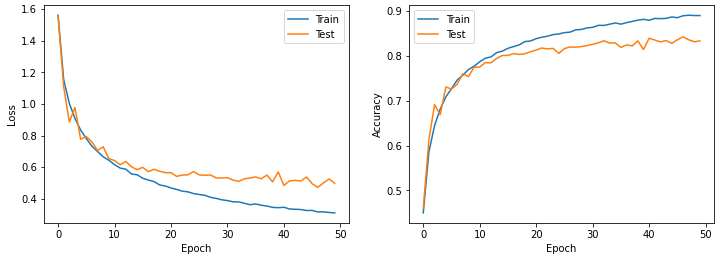

- DP-SGDを適用した場合 [(Jupyter Notebook)](https://github.com/toshi-4886/privacy_preserving_ML/blob/main/PyTorch/1_DPSGD_baseline.ipynb)

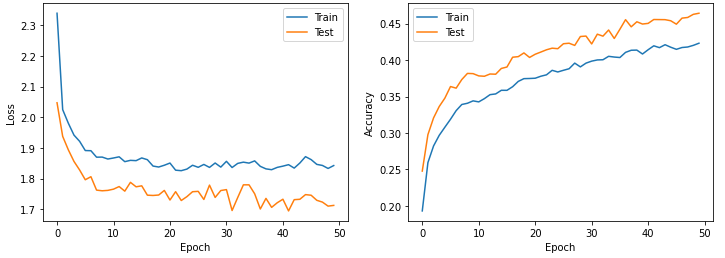

DP-SGDを適用するとテスト精度が85%程度から45%程度に低下していることが分かります。  
教師データに対する精度をテストデータに対する精度を比較すると、DP-SGDを適用しない場合は教師データの精度の方が高いですが、DP-SGDを適用すると教師データの精度の方が低くなっていることが分かります。

この結果から、学習時の正則化が強すぎて教師データの精度が十分に上がっていないことが考えられます。  
そこで、今回は下記の正則化の効果を検証します。
- data augmentation（画像の切り抜き、反転）
- optimizerのweight decay




### 参考資料
- Building an Image Classifier with Differential Privacy (Opacus Tutorials)  
https://opacus.ai/tutorials/building_image_classifier
- PyTorch Quickstart  
https://pytorch.org/tutorials/beginner/basics/quickstart_tutorial.html


# 実装

### 1. ライブラリのインポート
必要なライブラリをインポートします。

In [ ]:
import torch
import torchvision
from torch.utils.data import DataLoader
import sys
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics

!pip install 'opacus>=1.0'
import opacus
from opacus.validators import ModuleValidator
from opacus.utils.batch_memory_manager import BatchMemoryManager

import warnings
warnings.simplefilter("ignore")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.9/216.9 KB 3.7 MB/s eta 0:00:00


### 2. 実行環境の確認
使用するライブラリのバージョンや、GPU環境を確認します。  
Opacusは1.0.0で書き方が大きく変わっているので注意してください。  
[Google Colaboratory](https://colab.research.google.com/?hl=ja)で実行した際の例になります。

In [ ]:
print('Python:', sys.version)
print('PyTorch:', torch.__version__)
print('Torchvision:', torchvision.__version__)
print('Opacus:', opacus.__version__)
!nvidia-smi

Python: 3.9.16 (main, Dec  7 2022, 01:11:51) 
[GCC 9.4.0]
PyTorch: 1.13.1+cu116
Torchvision: 0.14.1+cu116
Opacus: 1.3.0
Sun Mar 12 03:44:07 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   67C    P0    32W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+---------------

### 3. データセットの用意  



#### データセットの取得
カラー画像データセットの[CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html)を、torchvisionを用いて取得します。  
今回は、**教師データにdata augmentationは適用せずに**、
教師データとテストデータに下記を適用します。
- ToTensor：データをTensor型に変換
- Normalize：各チャネルの平均が0、標準偏差が1となるように標準化


In [ ]:
CIFAR10_MEAN = (0.4914, 0.4822, 0.4465)
CIFAR10_STD = (0.2470, 0.2435, 0.2616)

training_data = torchvision.datasets.CIFAR10(
    root="data",
    train=True,
    download=True,
    transform=torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(), 
        torchvision.transforms.Normalize(CIFAR10_MEAN, CIFAR10_STD)]),
)


test_data = torchvision.datasets.CIFAR10(
    root="data",
    train=False,
    download=True,
    transform=torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(), 
        torchvision.transforms.Normalize(CIFAR10_MEAN, CIFAR10_STD)]),
)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


#### DataLoaderの作成
バッチ学習で利用できるように、DataLoaderを作成します。  
教師データのバッチサイズは一般的な128に設定します。  
学習データでは、バッチ作成時にランダムなデータを選択するためにshuffleをTrueに指定します。


In [ ]:
batch_size = 128
train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=1024, shuffle=False)

### 4. ニューラルネットワークの定義  
今回はtorchvisionのResNet18を使用します。  
詳細は下記論文を参照してください。  
[Very Deep Convolutional Networks for Large-Scale Image Recognition](https://arxiv.org/abs/1409.1556)




In [ ]:
model = torchvision.models.resnet18()

ResNet18にはBatch Normalizationが使われているため、DP-SGDの学習にはそのまま使うことはできません。  
そこで、ModuleValidatorを使用してGroup Normalizationに置き換えます。

In [ ]:
model = ModuleValidator.fix(model)

モデルは使用するデバイスを指定する必要があります。  
GPUを使用する場合は 'cuda' とします。


In [ ]:
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using {device} device")
model = model.to(device)

Using cuda device


### 5. 学習のための設定  
損失はクロスエントロピー、最適化方法は[Adam](https://arxiv.org/abs/1412.6980)を使用します。  
**まずは、data augmentationのみの効果を検証するため、weight_decay（過学習を防ぐためのパラメータの減衰率）は設定したままにします。**

In [ ]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

DP-SGDでは、パラメータ$\theta$を下記のように更新します。
$$
\theta_{i+1} \leftarrow \theta_i - \eta \left( \frac{1}{|B|} \sum_{(x,y)\in B} {\rm clip}_C (\nabla_{\theta}\ell(f(x), y)) + Z\right)
$$
ここで、$\ell$は損失関数、${\rm clip}_C$はL2ノルムを$C$に制限する関数、$Z$は多変量正規分布$\mathcal{N}(0,\sigma^2C^2\mathbb{I})$に従うノイズです。  

今回は、一般的なパラメータ$\sigma=1.0$と$C=1.0$を使用します。


In [ ]:
privacy_engine = opacus.PrivacyEngine()

model, optimizer, train_dataloader = privacy_engine.make_private(
    module=model,
    optimizer=optimizer,
    data_loader=train_dataloader,
    noise_multiplier=1.0,
    max_grad_norm=1.0,
)

### 6. 学習（data augmentationの検証）




#### 学習ループ
学習を50エポック実施します。  
学習結果を確認するために、各エポック終了時にテストデータの損失と精度も計算します。

バッチサイズが大きいとGPUメモリーエラーとなる場合があるので、BatchMemoryManagerを用います。  
学習で消費した$\epsilon$は、privacy_engine.get_epsilonで求めることができます。  
$\epsilon$は、差分プライバシーのパラメータで、値が小さいほどプライバシーが保護されていることになります。  


In [ ]:
train_loss = []
test_loss = []
train_acc = []
test_acc = []


for epoch in range(50):
    # training
        
    with BatchMemoryManager(
        data_loader=train_dataloader, 
        max_physical_batch_size=64, 
        optimizer=optimizer
    ) as memory_safe_data_loader:
        epoch_loss = []
        pred_list = []
        y_list = []
        model.train()
        for (X, y) in memory_safe_data_loader:
            X, y = X.to(device), y.to(device)

            # optimization step
            optimizer.zero_grad()
            pred = model(X)
            loss = criterion(pred, y)
            loss.backward()
            optimizer.step()

            epoch_loss.append(loss.item())
            y_list.extend(y.to('cpu').numpy().tolist())
            pred_list.extend(pred.argmax(1).to('cpu').numpy().tolist())

        train_loss.append(np.mean(epoch_loss))
        train_acc.append(metrics.accuracy_score(y_list, pred_list))

    # calculate epsilon
    epsilon = privacy_engine.get_epsilon(1e-5)
 
    # test
    model.eval()
    epoch_loss = []
    pred_list = []
    y_list = []
    with torch.no_grad():
        for X, y in test_dataloader:
            X, y = X.to(device), y.to(device)

            # predict
            pred = model(X)
            loss = criterion(pred, y)

            epoch_loss.append(loss.item())
            y_list.extend(y.to('cpu').numpy().tolist())
            pred_list.extend(pred.argmax(1).to('cpu').numpy().tolist())

    test_loss.append(np.mean(epoch_loss))
    test_acc.append(metrics.accuracy_score(y_list, pred_list))
    print(f'[Epoch {epoch}] (ε = {epsilon:.2f}, δ = {1e-5}) Train accuracy: {train_acc[-1]:0.2f}, Test accuracy: {test_acc[-1]:0.2f}, Train loss: {train_loss[-1]:0.3f}, Testloss: {test_loss[-1]:0.3f}')

  

[Epoch 0] (ε = 0.29, δ = 1e-05) Train accuracy: 0.24, Test accuracy: 0.29, Train loss: 2.264, Testloss: 1.969
[Epoch 1] (ε = 0.38, δ = 1e-05) Train accuracy: 0.32, Test accuracy: 0.32, Train loss: 1.893, Testloss: 1.854
[Epoch 2] (ε = 0.46, δ = 1e-05) Train accuracy: 0.36, Test accuracy: 0.37, Train loss: 1.808, Testloss: 1.801
[Epoch 3] (ε = 0.53, δ = 1e-05) Train accuracy: 0.36, Test accuracy: 0.36, Train loss: 1.816, Testloss: 1.802
[Epoch 4] (ε = 0.59, δ = 1e-05) Train accuracy: 0.37, Test accuracy: 0.38, Train loss: 1.793, Testloss: 1.798
[Epoch 5] (ε = 0.64, δ = 1e-05) Train accuracy: 0.38, Test accuracy: 0.38, Train loss: 1.785, Testloss: 1.811
[Epoch 6] (ε = 0.69, δ = 1e-05) Train accuracy: 0.39, Test accuracy: 0.39, Train loss: 1.784, Testloss: 1.780
[Epoch 7] (ε = 0.74, δ = 1e-05) Train accuracy: 0.40, Test accuracy: 0.40, Train loss: 1.786, Testloss: 1.831
[Epoch 8] (ε = 0.78, δ = 1e-05) Train accuracy: 0.40, Test accuracy: 0.40, Train loss: 1.796, Testloss: 1.802
[Epoch 9] 

#### 学習結果の表示
学習結果として、教師データとテストデータの損失と精度を描画します。

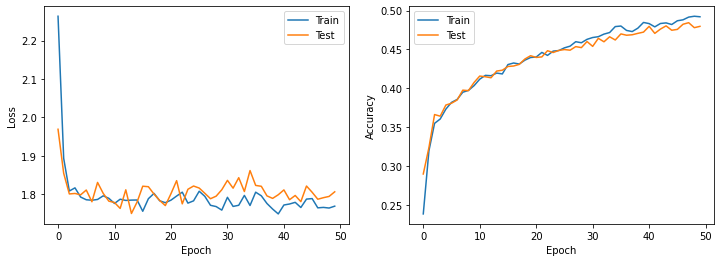

In [ ]:

plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(train_loss, label='Train')
plt.plot(test_loss, label='Test')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(122)
plt.plot(train_acc, label='Train')
plt.plot(test_acc, label='Test')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

想定通り、教師データとテストデータの精度が両方向上しました。  
教師データとテストデータの精度の差も小さく、data augmentationを適用しなくても過学習せずに学習できています。 


### 7. 学習（weight decayの検証）

次に、weight decayの効果を検証するために、「4. ニューラルネットワークの定義」からのコードを実行します。

In [ ]:
model = torchvision.models.resnet18()
model = ModuleValidator.fix(model)
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
model = model.to(device)

「5. 学習のための設定」では、weight decayの効果を検証するために、**weight_decayを0に設定します。**


In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=0)

privacy_engine = opacus.PrivacyEngine()
model, optimizer, train_dataloader = privacy_engine.make_private(
    module=model,
    optimizer=optimizer,
    data_loader=train_dataloader,
    noise_multiplier=1.0,
    max_grad_norm=1.0,
)

学習ループを実行します。


In [ ]:
train_loss = []
test_loss = []
train_acc = []
test_acc = []


for epoch in range(50):
    # training
        
    with BatchMemoryManager(
        data_loader=train_dataloader, 
        max_physical_batch_size=64, 
        optimizer=optimizer
    ) as memory_safe_data_loader:
        epoch_loss = []
        pred_list = []
        y_list = []
        model.train()
        for (X, y) in memory_safe_data_loader:
            X, y = X.to(device), y.to(device)

            # optimization step
            optimizer.zero_grad()
            pred = model(X)
            loss = criterion(pred, y)
            loss.backward()
            optimizer.step()

            epoch_loss.append(loss.item())
            y_list.extend(y.to('cpu').numpy().tolist())
            pred_list.extend(pred.argmax(1).to('cpu').numpy().tolist())

        train_loss.append(np.mean(epoch_loss))
        train_acc.append(metrics.accuracy_score(y_list, pred_list))

    # calculate epsilon
    epsilon = privacy_engine.get_epsilon(1e-5)
 
    # test
    model.eval()
    epoch_loss = []
    pred_list = []
    y_list = []
    with torch.no_grad():
        for X, y in test_dataloader:
            X, y = X.to(device), y.to(device)

            # predict
            pred = model(X)
            loss = criterion(pred, y)

            epoch_loss.append(loss.item())
            y_list.extend(y.to('cpu').numpy().tolist())
            pred_list.extend(pred.argmax(1).to('cpu').numpy().tolist())

    test_loss.append(np.mean(epoch_loss))
    test_acc.append(metrics.accuracy_score(y_list, pred_list))
    print(f'[Epoch {epoch}] (ε = {epsilon:.2f}, δ = {1e-5}) Train accuracy: {train_acc[-1]:0.2f}, Test accuracy: {test_acc[-1]:0.2f}, Train loss: {train_loss[-1]:0.3f}, Testloss: {test_loss[-1]:0.3f}')

  

[Epoch 0] (ε = 0.29, δ = 1e-05) Train accuracy: 0.23, Test accuracy: 0.29, Train loss: 2.289, Testloss: 1.967
[Epoch 1] (ε = 0.38, δ = 1e-05) Train accuracy: 0.31, Test accuracy: 0.31, Train loss: 1.915, Testloss: 1.897
[Epoch 2] (ε = 0.46, δ = 1e-05) Train accuracy: 0.34, Test accuracy: 0.34, Train loss: 1.861, Testloss: 1.843
[Epoch 3] (ε = 0.53, δ = 1e-05) Train accuracy: 0.35, Test accuracy: 0.36, Train loss: 1.839, Testloss: 1.829
[Epoch 4] (ε = 0.59, δ = 1e-05) Train accuracy: 0.36, Test accuracy: 0.36, Train loss: 1.816, Testloss: 1.820
[Epoch 5] (ε = 0.64, δ = 1e-05) Train accuracy: 0.38, Test accuracy: 0.38, Train loss: 1.798, Testloss: 1.862
[Epoch 6] (ε = 0.69, δ = 1e-05) Train accuracy: 0.39, Test accuracy: 0.38, Train loss: 1.810, Testloss: 1.850
[Epoch 7] (ε = 0.74, δ = 1e-05) Train accuracy: 0.39, Test accuracy: 0.39, Train loss: 1.824, Testloss: 1.817
[Epoch 8] (ε = 0.78, δ = 1e-05) Train accuracy: 0.40, Test accuracy: 0.40, Train loss: 1.796, Testloss: 1.810
[Epoch 9] 

学習結果を表示します。

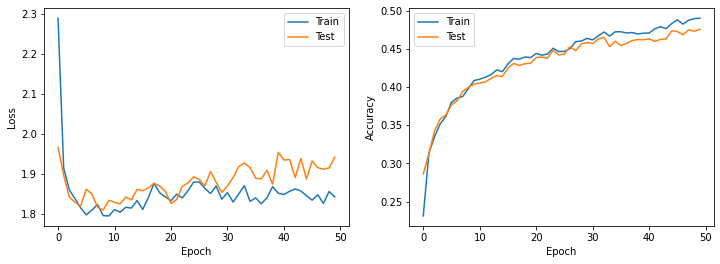

In [ ]:

plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(train_loss, label='Train')
plt.plot(test_loss, label='Test')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(122)
plt.plot(train_acc, label='Train')
plt.plot(test_acc, label='Test')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

weight_decayを0にしても、テスト精度は変わりませんでした。  
教師データとテストデータの精度の差も小さく、過学習もしていません。  
ただし、test lossが徐々に上昇していて学習が少し不安定な感じがします。  
この結果を踏まえて、今後もweight decayは適用したいと思います。

# おわりに


### 今回の結果
今回の設定では、テスト精度が48%まで改善しました。   
ただし、差分プライバシーを適用しない場合（85%程度）と比較すると大幅に低い値となっています。  


### 結果の考察
差分プライバシーを適用しない場合は、過学習を防ぐためには正則化が必須でした。  
一方で、DP-SGDの学習では、data augmentationとweight decayを適用しなくても過学習がおきず、正則化の効果はありませんでした。  
DP-SGDは、学習時にノイズを付加しているため過学習しずらく、このような結果になったと考えられます。


## 次にやること
最適化の設定を変えることでDP-SGDのテスト精度を改善できないか検討したいと思います。